In [1]:
import numpy as np
import matplotlib.pyplot as plt
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 15}
plt.rc('font', **font)
import os
np.random.seed(1122334455)
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

In [2]:
if not os.path.exists("plots/"):
    os.mkdir("plots")

In [3]:
At = np.asarray([
    [1, 0, 1, 0],
    [0, 1, 0, 1],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])
Bt = np.asarray([
    [0.5, 0.0],
    [0.0, 0.5],
    [1.0, 0.0],
    [0.0, 1.0]
])
Ct = np.asarray([
    [1, 0, 0, 0],
    [0, 1, 0, 0]
])

In [4]:
sigma_rx = 1.0
sigma_ry = 1.0
sigma_rxdot = 0.01
sigma_rydot = 0.01
dx = 0
dy = 0
sigma_q = 10

def ut():
    return np.asarray([[dx], [dy]])

def R():
    R = np.asarray([
        [sigma_rx**2, 0, 0, 0],
        [0, sigma_ry**2, 0, 0],
        [0, 0, sigma_rxdot**2, 0],
        [0, 0, 0, sigma_rydot**2]
    ])
    return R
    
def Q():
    return np.eye(2)*(sigma_q**2)

In [5]:
def noise(cov):
    return np.random.multivariate_normal(np.zeros(cov.shape[0]), cov).reshape(-1,1)

In [6]:
## The code for drawing ellipses is inspired from https://matplotlib.org/devdocs/gallery/statistics/confidence_ellipse.html
def draw_ellipse(mu, sigma, ax):
    
    p = sigma[0, 1]/np.sqrt(sigma[0, 0] * sigma[1, 1])
    ellipse = Ellipse((0, 0), width=2*np.sqrt(1+p), height=2*np.sqrt(1-p), edgecolor="red", facecolor=None)
    s_x, s_y = np.sqrt(sigma[0,0]), np.sqrt(sigma[1,1])
    transf = transforms.Affine2D() \
    .rotate_deg(45) \
    .scale(s_x, s_y) \
    .translate(mu[0, 0], mu[1, 0])
    
    ellipse.set_transform(transf + ax.transData)
    ax.add_patch(ellipse)

In [7]:
#Constant of Sine and Cosine
k = 0.5

## Part A

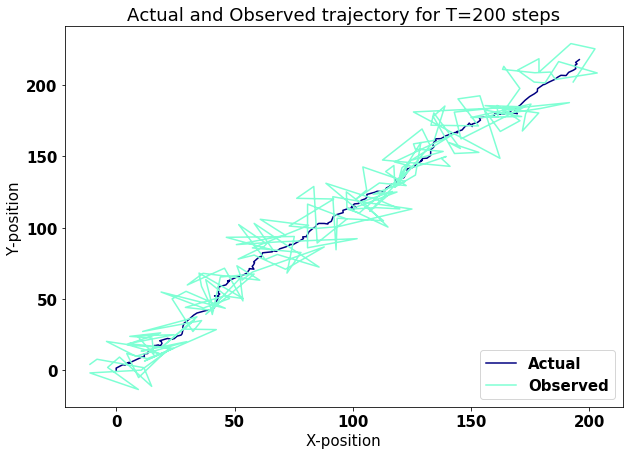

In [8]:
T = 200
initial_x = 0
initial_y = 0
vel_x = 1
vel_y = 1
X = np.asarray([[initial_x],[initial_y],[vel_x],[vel_y]])
actual = [X]
observed = [X[:2, :] + noise(Q())]
for i in range(T):
    X = (At @ X) + noise(R())
    actual.append(X)
    observed.append(X[:2, :] + noise(Q()))
actual = np.asarray(actual)
observed = np.asarray(observed)

fig, ax = plt.subplots(1, 1, figsize =(10, 7))
ax.plot(actual[:, 0, 0], actual[:, 1, 0], label="Actual", color="navy")
ax.plot(observed[:, 0, 0], observed[:, 1, 0], label="Observed", color="aquamarine")

ax.set_title("Actual and Observed trajectory for T="+str(T)+" steps")
ax.set_xlabel("X-position")
ax.set_ylabel("Y-position")
ax.legend(loc='lower right')
fig.savefig("plots/a_trajectory_t_"+str(T)+".png", bbox_inches="tight")
plt.show()

## Part B

In [9]:
def kalman(mu, sigma, u, z):
    mu1 = (At @ mu) + (Bt @ u)
    sigma1 = (At @ sigma @ At.T) + R()
    kt = sigma1 @ Ct.T @ np.linalg.pinv((Ct @ sigma1 @ Ct.T) + Q())
    new_mu = mu1 + (kt @ (z - (Ct @ mu1)))
    new_sigma = (np.eye(sigma1.shape[0]) - (kt @ Ct)) @ sigma1
    return new_mu, new_sigma

## Part C

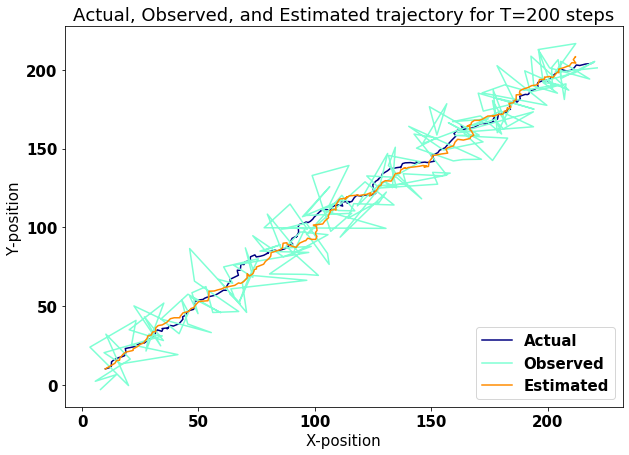

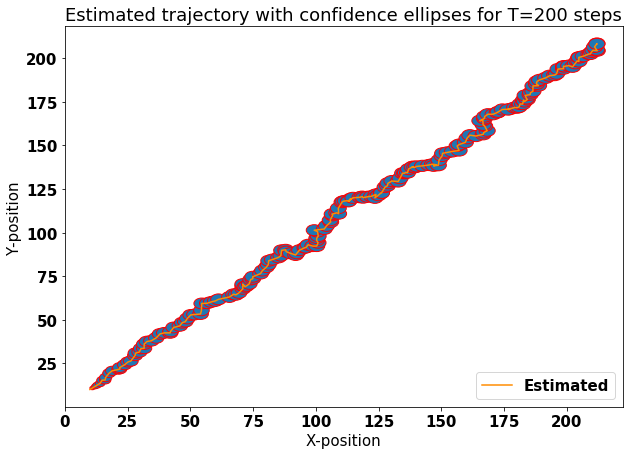

In [10]:
T = 200
initial_x = 10
initial_y = 10
vel_x = 1
vel_y = 1
X = np.asarray([[initial_x],[initial_y],[vel_x],[vel_y]])
mu = X
std = 0.01
sigma_q = 10
sigma = np.eye(mu.shape[0])*(std**2)
actual = [X]
observed = [(Ct @ X) + noise(Q())]
estimated_pos = [mu]
estimated_dev = [sigma]
for i in range(T):
    new_mu, new_sigma = kalman(estimated_pos[-1], estimated_dev[-1], ut(), observed[-1])
    estimated_pos.append(new_mu)
    estimated_dev.append(new_sigma)
    X = (At @ X) + noise(R())
    actual.append(X)
    observed.append((Ct @ X) + noise(Q()))
    
actual = np.asarray(actual)
observed = np.asarray(observed)
estimated_pos = np.asarray(estimated_pos)
estimated_dev = np.asarray(estimated_dev)

fig, ax = plt.subplots(1, 1, figsize =(10, 7))
ax.plot(actual[:, 0, 0], actual[:, 1, 0], label="Actual", color="navy")
ax.plot(observed[:, 0, 0], observed[:, 1, 0], label="Observed", color="aquamarine")
ax.plot(estimated_pos[:, 0, 0], estimated_pos[:, 1, 0], label="Estimated", color="darkorange")

ax.set_title("Actual, Observed, and Estimated trajectory for T="+str(T)+" steps")
ax.set_xlabel("X-position")
ax.set_ylabel("Y-position")
ax.legend(loc='lower right')
fig.savefig("plots/c_trajectory_t_"+str(T)+".png", bbox_inches="tight")
plt.show()

fig, ax = plt.subplots(1, 1, figsize =(10, 7))
ax.plot(estimated_pos[:, 0, 0], estimated_pos[:, 1, 0], label="Estimated", color="darkorange")
for j in range(len(estimated_dev)):
    draw_ellipse(estimated_pos[j], estimated_dev[j], ax)
    
ax.set_title("Estimated trajectory with confidence ellipses for T="+str(T)+" steps")
ax.set_xlabel("X-position")
ax.set_ylabel("Y-position")
ax.legend(loc='lower right')
fig.savefig("plots/c_ellipses_t_"+str(T)+".png", bbox_inches="tight")
plt.show()

## Part D

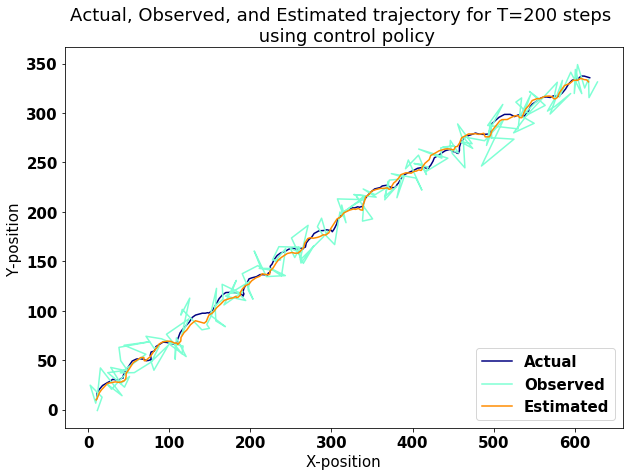

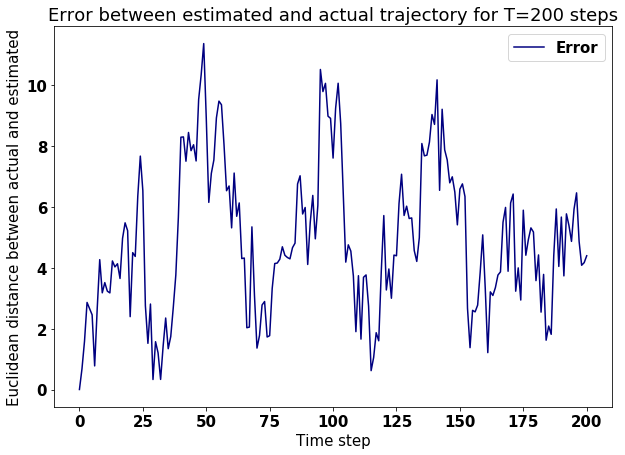

In [11]:
T = 200
initial_x = 10
initial_y = 10
vel_x = 1
vel_y = 1
X = np.asarray([[initial_x],[initial_y],[vel_x],[vel_y]])
mu = X
std = 0.01
sigma_q = 10
sigma = np.eye(mu.shape[0])*(std**2)
actual = [X]
observed = [(Ct @ X) + noise(Q())]
estimated_pos = [mu]
estimated_dev = [sigma]
for i in range(T):
    dx = np.sin(k*i)
    dy = np.cos(k*i)
    new_mu, new_sigma = kalman(estimated_pos[-1], estimated_dev[-1], ut(), observed[-1])
    estimated_pos.append(new_mu)
    estimated_dev.append(new_sigma)
    X = (At @ X) + (Bt @ ut()) + noise(R())
    actual.append(X)
    observed.append((Ct @ X) + noise(Q()))
    
actual = np.asarray(actual)
observed = np.asarray(observed)
estimated_pos = np.asarray(estimated_pos)
estimated_dev = np.asarray(estimated_dev)

fig, ax = plt.subplots(1, 1, figsize =(10, 7))
ax.plot(actual[:, 0, 0], actual[:, 1, 0], label="Actual", color="navy")
ax.plot(observed[:, 0, 0], observed[:, 1, 0], label="Observed", color="aquamarine")
ax.plot(estimated_pos[:, 0, 0], estimated_pos[:, 1, 0], label="Estimated", color="darkorange")

ax.set_title("Actual, Observed, and Estimated trajectory for T="+str(T)+" steps \n using control policy")
ax.set_xlabel("X-position")
ax.set_ylabel("Y-position")
ax.legend(loc='lower right')
fig.savefig("plots/d_trajectory_t_"+str(T)+".png", bbox_inches="tight")
plt.show()

error = np.sqrt((estimated_pos[:, 1, 0] - actual[:, 1, 0])**2 + (estimated_pos[:, 0, 0] - actual[:, 0, 0])**2)
xticks = np.arange(len(error))
fig, ax = plt.subplots(1, 1, figsize =(10, 7))
ax.plot(xticks, error, label="Error", color="navy")

ax.set_title("Error between estimated and actual trajectory for T="+str(T)+" steps")
ax.set_ylabel("Euclidean distance between actual and estimated")
ax.set_xlabel("Time step")
ax.legend(loc='upper right')
fig.savefig("plots/d_error_t_"+str(T)+".png", bbox_inches="tight")
plt.show()

## Part E

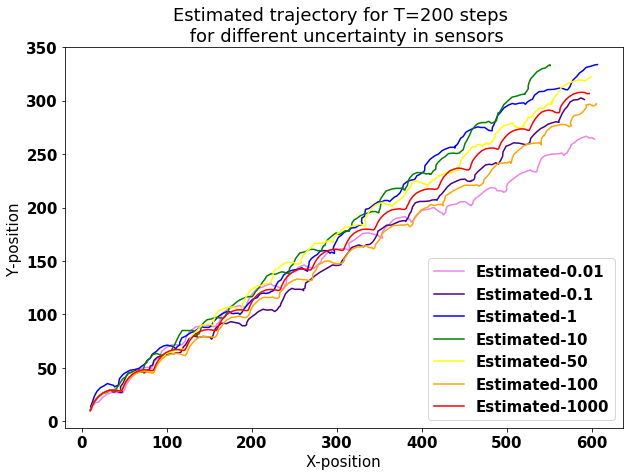

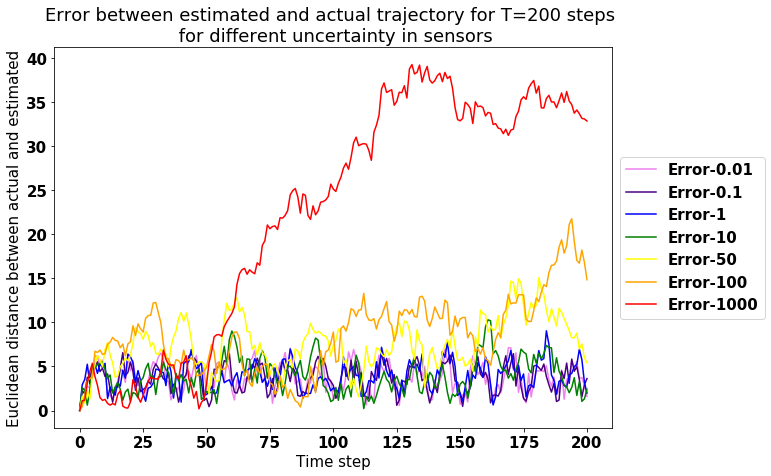

In [18]:
fig, ax = plt.subplots(1, 1, figsize =(10, 7))
fig2, ax2 = plt.subplots(1, 1, figsize =(10, 7))
sigmas = [0.01, 0.1, 1, 10, 50, 100, 1000]
colors = ["violet", "indigo", "blue", "green", "yellow", "orange", "red"]
for n in range(len(sigmas)):
    sigma_q = sigmas[n]
    T = 200
    initial_x = 10
    initial_y = 10
    vel_x = 1
    vel_y = 1
    X = np.asarray([[initial_x],[initial_y],[vel_x],[vel_y]])
    actual = [X]
    mu = X
    std = 0.01
    sigma = np.eye(mu.shape[0])*(std**2)
    observed = [(Ct @ X) + noise(Q())]
    estimated_pos = [mu]
    estimated_dev = [sigma]
    for i in range(T):
        dx = np.sin(k*i)
        dy = np.cos(k*i)
        new_mu, new_sigma = kalman(estimated_pos[-1], estimated_dev[-1], ut(), observed[-1])
        estimated_pos.append(new_mu)
        estimated_dev.append(new_sigma)
        X = (At @ X) + (Bt @ ut()) + noise(R())
        actual.append(X)
        observed.append((Ct @ X) + noise(Q()))

    estimated_pos = np.asarray(estimated_pos)
    actual = np.asarray(actual)
    
    ax.plot(estimated_pos[:, 0, 0], estimated_pos[:, 1, 0], label="Estimated-"+str(sigma_q), color=colors[n])
    error = np.sqrt((estimated_pos[:, 1, 0] - actual[:, 1, 0])**2 + (estimated_pos[:, 0, 0] - actual[:, 0, 0])**2)
    xticks = np.arange(len(error))
    ax2.plot(xticks, error, label="Error-"+str(sigma_q), color=colors[n])

ax.set_title("Estimated trajectory for T="+str(T)+" steps \n for different uncertainty in sensors")
ax.set_xlabel("X-position")
ax.set_ylabel("Y-position")
ax.legend(loc='lower right')
fig.savefig("plots/e_trajectory_t_"+str(T)+".png", bbox_inches="tight")

ax2.set_title("Error between estimated and actual trajectory for T="+str(T)+" steps \n for different uncertainty in sensors")
ax2.set_ylabel("Euclidean distance between actual and estimated")
ax2.set_xlabel("Time step")
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig2.savefig("plots/e_error_t_"+str(T)+".png", bbox_inches="tight")
plt.show()

## Part F

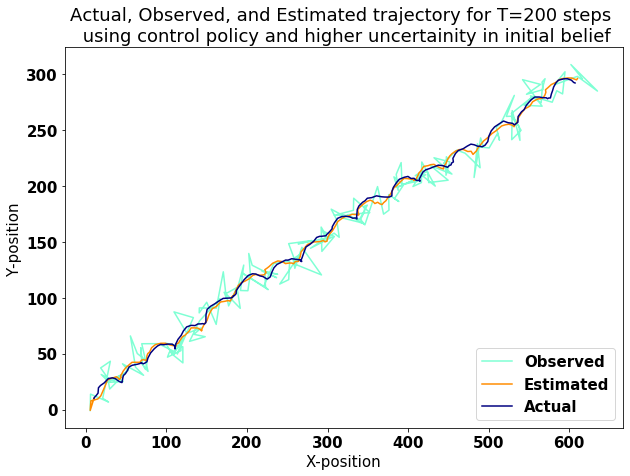

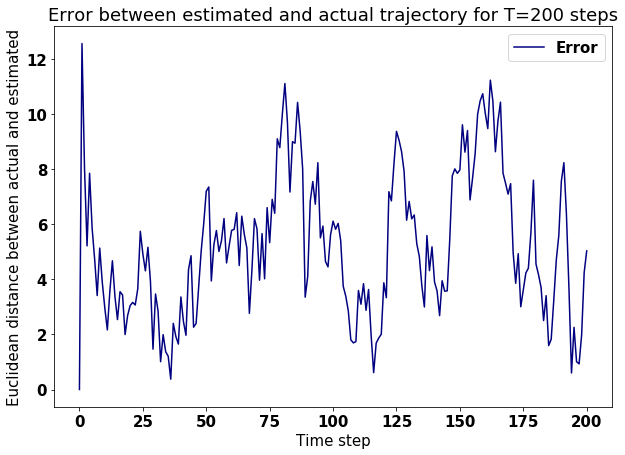

In [13]:
T = 200
initial_x = 10
initial_y = 10
vel_x = 1
vel_y = 1
X = np.asarray([[initial_x],[initial_y],[vel_x],[vel_y]])
mu = X
std = 0.01
sigma_q = 10
sigma = np.eye(mu.shape[0])*(std**2)
sigma[0][0] = 100**2
sigma[1][1] = 100**2
actual = [X]
observed = [(Ct @ X) + noise(Q())]
estimated_pos = [mu]
estimated_dev = [sigma]
for i in range(T):
    dx = np.sin(k*i)
    dy = np.cos(k*i)
    new_mu, new_sigma = kalman(estimated_pos[-1], estimated_dev[-1], ut(), observed[-1])
    estimated_pos.append(new_mu)
    estimated_dev.append(new_sigma)
    X = (At @ X) + (Bt @ ut()) + noise(R())
    actual.append(X)
    observed.append((Ct @ X) + noise(Q()))
    
actual = np.asarray(actual)
observed = np.asarray(observed)
estimated_pos = np.asarray(estimated_pos)
estimated_dev = np.asarray(estimated_dev)

fig, ax = plt.subplots(1, 1, figsize =(10, 7))
ax.plot(observed[:, 0, 0], observed[:, 1, 0], label="Observed", color="aquamarine")
ax.plot(estimated_pos[:, 0, 0], estimated_pos[:, 1, 0], label="Estimated", color="darkorange")
ax.plot(actual[:, 0, 0], actual[:, 1, 0], label="Actual", color="navy")

ax.set_title("Actual, Observed, and Estimated trajectory for T="+str(T)+" steps \n using control policy and higher uncertainity in initial belief")
ax.set_xlabel("X-position")
ax.set_ylabel("Y-position")
ax.legend(loc='lower right')
fig.savefig("plots/f_trajectory_t_"+str(T)+".png", bbox_inches="tight")
plt.show()

error = np.sqrt((estimated_pos[:, 1, 0] - actual[:, 1, 0])**2 + (estimated_pos[:, 0, 0] - actual[:, 0, 0])**2)
xticks = np.arange(len(error))
fig, ax = plt.subplots(1, 1, figsize =(10, 7))
ax.plot(xticks, error, label="Error", color="navy")

ax.set_title("Error between estimated and actual trajectory for T="+str(T)+" steps")
ax.set_ylabel("Euclidean distance between actual and estimated")
ax.set_xlabel("Time step")
ax.legend(loc='upper right')
fig.savefig("plots/f_error_t_"+str(T)+".png", bbox_inches="tight")
plt.show()

## Part G

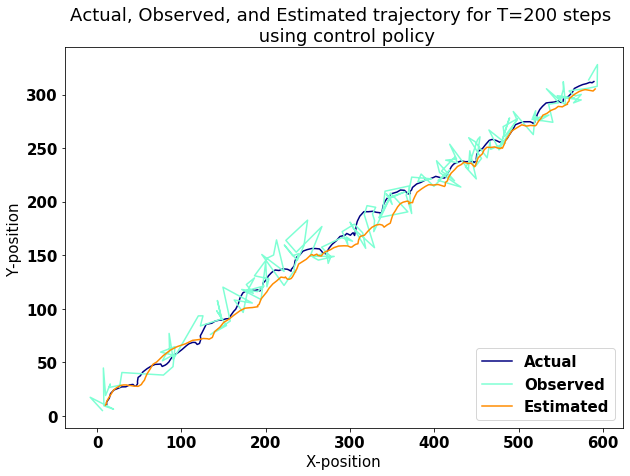

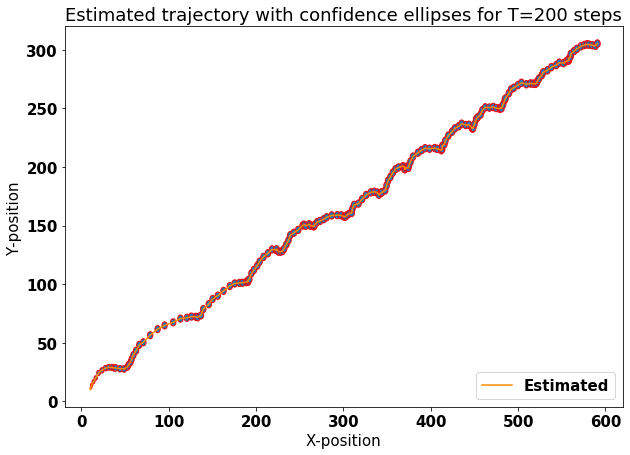

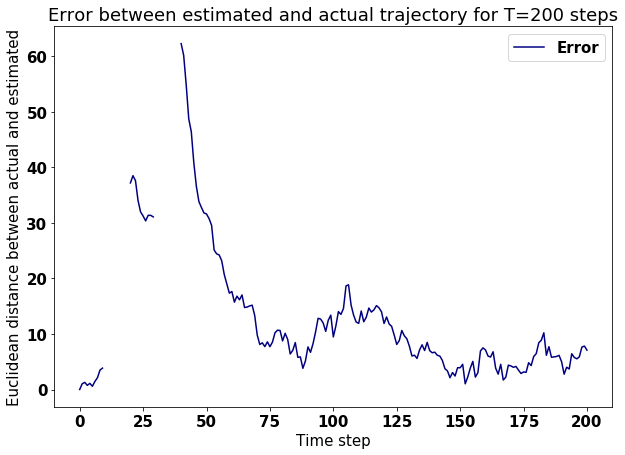

In [14]:
T = 200
initial_x = 10
initial_y = 10
vel_x = 1
vel_y = 1
X = np.asarray([[initial_x],[initial_y],[vel_x],[vel_y]])
mu = X
std = 0.01
sigma_q = 10
sigma = np.eye(mu.shape[0])*(std**2)
actual = [X]
observed = [(Ct @ X) + noise(Q())]
estimated_pos = [mu]
estimated_dev = [sigma]
for i in range(T):
    dx = np.sin(k*i)
    dy = np.cos(k*i)
    X = (At @ X) + (Bt @ ut()) + noise(R())
    actual.append(X)
    if not((i>=10 and i<20) or (i>=30 and i<40)):
        new_mu, new_sigma = kalman(estimated_pos[-1], estimated_dev[-1], ut(), observed[-1])
        estimated_pos.append(new_mu)
        estimated_dev.append(new_sigma)
        observed.append((Ct @ X) + noise(Q()))
    
actual = np.asarray(actual)
observed = np.asarray(observed)
estimated_pos = np.asarray(estimated_pos)
estimated_dev = np.asarray(estimated_dev)

fig, ax = plt.subplots(1, 1, figsize =(10, 7))
ax.plot(actual[:, 0, 0], actual[:, 1, 0], label="Actual", color="navy")
ax.plot(observed[:, 0, 0], observed[:, 1, 0], label="Observed", color="aquamarine")
ax.plot(estimated_pos[:, 0, 0], estimated_pos[:, 1, 0], label="Estimated", color="darkorange")

ax.set_title("Actual, Observed, and Estimated trajectory for T="+str(T)+" steps \n using control policy")
ax.set_xlabel("X-position")
ax.set_ylabel("Y-position")
ax.legend(loc='lower right')
fig.savefig("plots/g_trajectory_t_"+str(T)+".png", bbox_inches="tight")
plt.show()

fig, ax = plt.subplots(1, 1, figsize =(10, 7))
ax.plot(estimated_pos[:, 0, 0], estimated_pos[:, 1, 0], label="Estimated", color="darkorange")
for j in range(len(estimated_dev)):
    draw_ellipse(estimated_pos[j], estimated_dev[j], ax)
    
ax.set_title("Estimated trajectory with confidence ellipses for T="+str(T)+" steps")
ax.set_xlabel("X-position")
ax.set_ylabel("Y-position")
ax.legend(loc='lower right')
fig.savefig("plots/g_ellipses_t_"+str(T)+".png", bbox_inches="tight")
plt.show()

error = list(np.sqrt((estimated_pos[:10, 1, 0] - actual[:10, 1, 0])**2 + (estimated_pos[:10, 0, 0] - actual[:10, 0, 0])**2))
error += list(np.empty(10)*np.nan)
error += list(np.sqrt((estimated_pos[10:20, 1, 0] - actual[20:30, 1, 0])**2 + (estimated_pos[10:20, 0, 0] - actual[20:30, 0, 0])**2))
error += list(np.empty(10)*np.nan)
error += list(np.sqrt((estimated_pos[20:, 1, 0] - actual[40:, 1, 0])**2 + (estimated_pos[20:, 0, 0] - actual[40:, 0, 0])**2))
xticks = np.arange(len(error))
fig, ax = plt.subplots(1, 1, figsize =(10, 7))
ax.plot(xticks, error, label="Error", color="navy")

ax.set_title("Error between estimated and actual trajectory for T="+str(T)+" steps")
ax.set_ylabel("Euclidean distance between actual and estimated")
ax.set_xlabel("Time step")
ax.legend(loc='upper right')
fig.savefig("plots/g_error_t_"+str(T)+".png", bbox_inches="tight")
plt.show()

## Part H

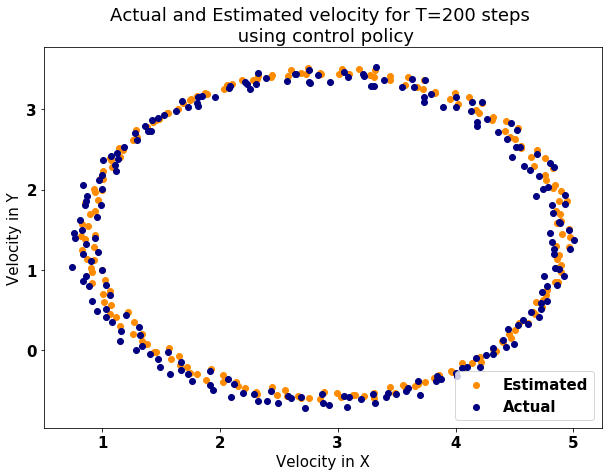

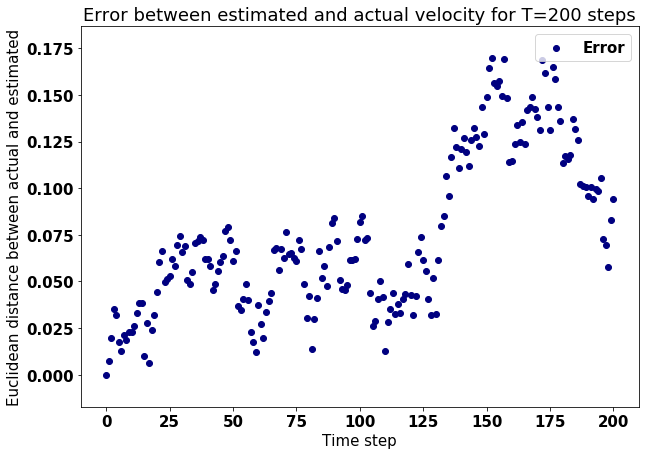

In [15]:
T = 200
initial_x = 10
initial_y = 10
vel_x = 1
vel_y = 1
X = np.asarray([[initial_x],[initial_y],[vel_x],[vel_y]])
mu = X
std = 0.01
sigma_q = 10
sigma = np.eye(mu.shape[0])*(std**2)
actual = [X]
estimated_pos = [mu]
estimated_dev = [sigma]
observed = [(Ct @ X) + noise(Q())]
for i in range(T):
    dx = np.sin(k*i)
    dy = np.cos(k*i)
    new_mu, new_sigma = kalman(estimated_pos[-1], estimated_dev[-1], ut(), observed[-1])
    estimated_pos.append(new_mu)
    estimated_dev.append(new_sigma)
    X = (At @ X) + (Bt @ ut()) + noise(R())
    actual.append(X)
    observed.append((Ct @ X) + noise(Q()))
    
actual = np.asarray(actual)
estimated_pos = np.asarray(estimated_pos)
estimated_dev = np.asarray(estimated_dev)

fig, ax = plt.subplots(1, 1, figsize =(10, 7))
ax.scatter(estimated_pos[:, 2, 0], estimated_pos[:, 3, 0], label="Estimated", color="darkorange")
ax.scatter(actual[:, 2, 0], actual[:, 3, 0], label="Actual", color="navy")

ax.set_title("Actual and Estimated velocity for T="+str(T)+" steps \n using control policy")
ax.set_xlabel("Velocity in X")
ax.set_ylabel("Velocity in Y")
ax.legend(loc='lower right')
fig.savefig("plots/h_velocity_t_"+str(T)+".png", bbox_inches="tight")
plt.show()

error = np.sqrt((estimated_pos[:, 2, 0] - actual[:, 2, 0])**2 + (estimated_pos[:, 3, 0] - actual[:, 3, 0])**2)
xticks = np.arange(len(error))
fig, ax = plt.subplots(1, 1, figsize =(10, 7))
ax.scatter(xticks, error, label="Error", color="navy")

ax.set_title("Error between estimated and actual velocity for T="+str(T)+" steps")
ax.set_ylabel("Euclidean distance between actual and estimated")
ax.set_xlabel("Time step")
ax.legend(loc='upper right')
fig.savefig("plots/h_error_vel_t_"+str(T)+".png", bbox_inches="tight")
plt.show()

## Part I

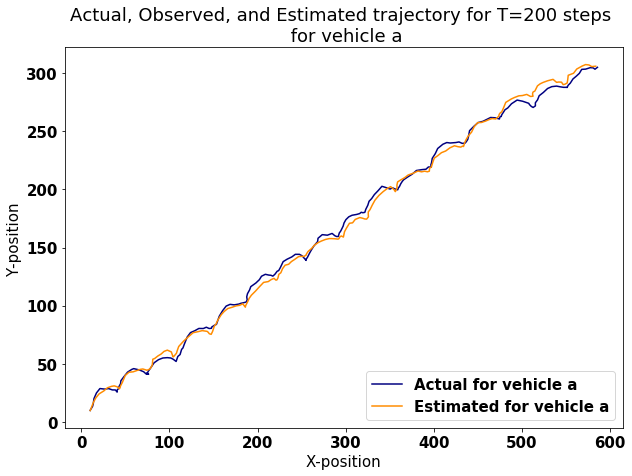

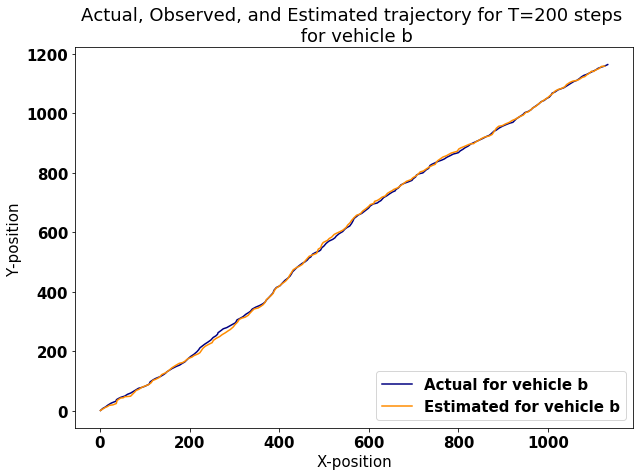

In [21]:
T = 200
X_a = np.asarray([[10],[10],[1],[1]])
X_b = np.asarray([[1],[1],[5],[5]])
std_a = 0.01
std_b = 1
sigma_q = 10
actual_a = [X_a]
actual_b = [X_b]
observed_1 = [(Ct @ X_a) + noise(Q())]
observed_2 = [(Ct @ X_b) + noise(Q())]
estimated_pos_a = [X_a]
estimated_dev_a = [np.eye(mu.shape[0])*(std_a**2)]
estimated_pos_b = [X_b]
estimated_dev_b = [np.eye(mu.shape[0])*(std_b**2)]
for i in range(T):
    dx, dy = np.sin(k*i), np.cos(k*i)
    sigma_rx, sigma_ry, sigma_rxdot, sigma_rydot = 1.0, 1.0, 0.01, 0.01
    X_a = (At @ X_a) + (Bt @ ut()) + noise(R())
    actual_a.append(X_a)
    new_mu1, new_sigma1 = kalman(estimated_pos_a[-1], estimated_dev_a[-1], ut(), observed_1[-1])
    new_mu2, new_sigma2 = kalman(estimated_pos_a[-1], estimated_dev_a[-1], ut(), observed_2[-1])
    
    dx, dy = np.sin(2*k*i), np.cos(2*k*i)
    sigma_rx, sigma_ry, sigma_rxdot, sigma_rydot = 1.5, 1.5, 0.1, 0.1
    X_b = (At @ X_b) + (Bt @ ut()) + noise(R())
    actual_b.append(X_b)
    new_mu3, new_sigma3 = kalman(estimated_pos_b[-1], estimated_dev_b[-1], ut(), observed_1[-1])
    new_mu4, new_sigma4 = kalman(estimated_pos_b[-1], estimated_dev_b[-1], ut(), observed_2[-1])
    
    sig = [new_sigma1, new_sigma2, new_sigma3, new_sigma4]
    mus = [new_mu1, new_mu2, new_mu3, new_mu4]
    norms = [np.linalg.norm(m, 'fro') for m in sig]
    min_index = np.argmin(np.asarray(norms))
    v1, o1 = min_index//2, min_index%2
    v2, o2 = (1-v1), (1-o1)
    eval("estimated_pos_"+("b" if v1 else "a")).append(mus[2*v1+o1])
    eval("estimated_dev_"+("b" if v1 else "a")).append(sig[2*v1+o1])
    eval("estimated_pos_"+("b" if v2 else "a")).append(mus[2*v2+o2])
    eval("estimated_dev_"+("b" if v2 else "a")).append(sig[2*v2+o2])
    eval("observed_"+( "2" if o1 else "1")).append((Ct @ (X_b if v1 else X_a)) + noise(Q()))
    eval("observed_"+( "2" if o2 else "1")).append((Ct @ (X_b if v2 else X_a)) + noise(Q()))
    
actual_a = np.asarray(actual_a)
estimated_pos_a = np.asarray(estimated_pos_a)

fig, ax = plt.subplots(1, 1, figsize =(10, 7))
ax.plot(actual_a[:, 0, 0], actual_a[:, 1, 0], label="Actual for vehicle a", color="navy")
ax.plot(estimated_pos_a[:, 0, 0], estimated_pos_a[:, 1, 0], label="Estimated for vehicle a", color="darkorange")

ax.set_title("Actual, Observed, and Estimated trajectory for T="+str(T)+" steps \n for vehicle a")
ax.set_xlabel("X-position")
ax.set_ylabel("Y-position")
ax.legend(loc='lower right')
fig.savefig("plots/i_trajectory_a_t_"+str(T)+".png", bbox_inches="tight")
plt.show()

actual_b = np.asarray(actual_b)
estimated_pos_b = np.asarray(estimated_pos_b)

fig, ax = plt.subplots(1, 1, figsize =(10, 7))
ax.plot(actual_b[:, 0, 0], actual_b[:, 1, 0], label="Actual for vehicle b", color="navy")
ax.plot(estimated_pos_b[:, 0, 0], estimated_pos_b[:, 1, 0], label="Estimated for vehicle b", color="darkorange")

ax.set_title("Actual, Observed, and Estimated trajectory for T="+str(T)+" steps \n for vehicle b")
ax.set_xlabel("X-position")
ax.set_ylabel("Y-position")
ax.legend(loc='lower right')
fig.savefig("plots/i_trajectory_b_t_"+str(T)+".png", bbox_inches="tight")
plt.show()